## Setup

In [ ]:
!pip install geopandas

In [3]:
import pandas as pd
import io
from google.colab import files
import altair
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

In [4]:
uploaded = files.upload()

Saving data_clean.csv to data_clean.csv


In [8]:
df = pd.read_csv(io.BytesIO(uploaded['data_clean.csv']), index_col=0)
df.date_time_utc = pd.to_datetime(df.date_time_utc)

### Useful code

In [9]:
def Cross_tab(initial_df, feature):
    return pd.crosstab(index = initial_df[feature], columns='Count').reset_index().sort_values(by='Count', ascending = False)

### Preprocessing

In [10]:
#renaming Countries for geopandas 
df.Countries = df.Countries.str.replace(r'(^.*CONGO.*$)', 'Dem. Rep. Congo')
df.Countries = df.Countries.str.replace(r'(^.*DOMINICA.*$)', 'Dominican Rep.')
df.Countries = df.Countries.str.replace(r'(^.*FALKLAND.*$)', 'Falkland Is.')
df.Countries = df.Countries.str.replace(r'(^.*PAPUA.*$)', 'Papua New Guinea')
df.Countries = df.Countries.str.replace(r'(^.*CZECH.*$)', 'Czechia')



#creating crosstab on Countries
country_df = Cross_tab(df, 'Countries')
countries_capitalized = []
for i in country_df.Countries:
  countries_capitalized.append(i.title())
country_df.Countries = countries_capitalized

#second round of renaming
country_df.Countries = country_df.Countries.str.replace(r'(^.*U.S..*$)', 'United States of America')
country_df.Countries = country_df.Countries.str.replace(r'(^.*Bosnia And Herzegovina.*$)', 'Bosnia and Herz.')
country_df.Countries = country_df.Countries.str.replace(r'(^.*Solomon Islands.*$)', 'Solomon Is.')
country_df.Countries = country_df.Countries.str.replace(r'(^.*Tobago.*$)', 'Trinidad and Tobago')
country_df.Countries = country_df.Countries.str.replace(r'(^.*U.K..*$)', 'United Kingdom')

# Read the geopandas dataset and merge with countries_df
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_gdf = world.merge(country_df, how="left", left_on=['name'], right_on=['Countries'])

# Clean data: remove rows with no data
country_gdf = country_gdf.dropna(subset=['Countries', 'Count'])
#country_gdf = country_gdf.loc[country_gdf.Countries != 'United States of America']

# EDA

## Global earthquakes

### Countries by earthquakes per year

In [18]:
#Creating subset with only 2020 earhquakes
df_2020 = df.loc[df.date_time_utc.dt.year == 2020]

In [19]:
!pip install mapclassify

In [20]:
#creating crosstab by date, that will show total quantity earthquakes per country
countries = pd.crosstab(index = df_2020.Countries, columns='Count').reset_index().sort_values(by='Count', ascending = False)
countries.head()

col_0,Countries,Count
220,U.S.,28251
133,MEXICO,11048
95,INDONESIA,6401
216,TURKEY,5721
48,CHILE,5421


/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:561: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  FutureWarning,


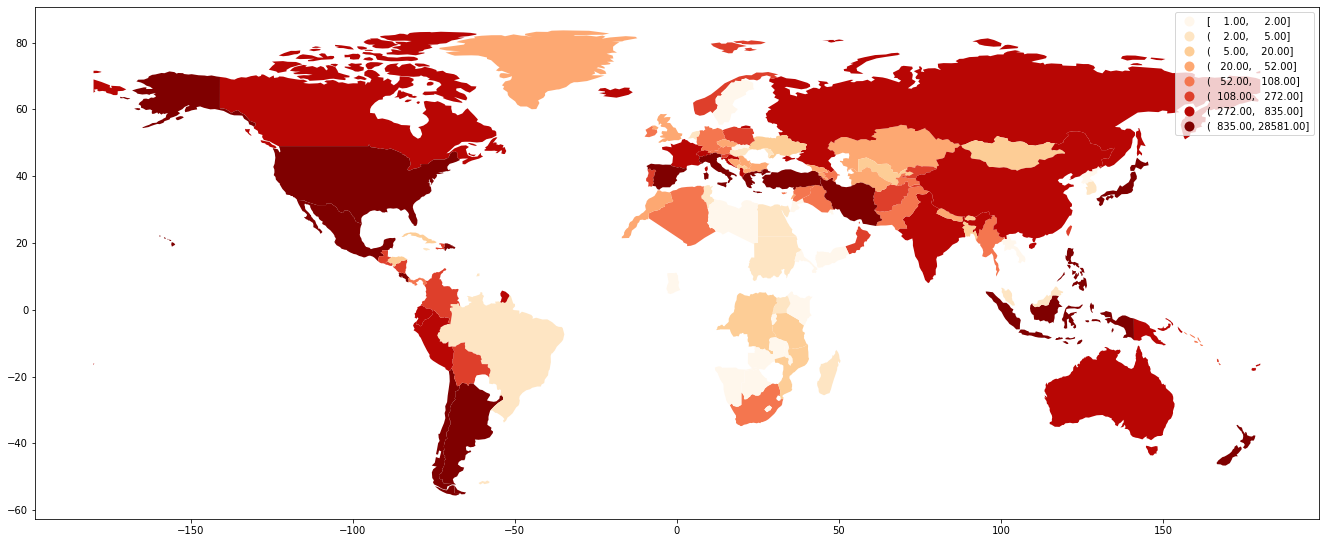

In [21]:
country_gdf.plot(column='Count', scheme='QUANTILES', k=8, colormap='OrRd', legend=True, figsize =(23,20),)

We can see that top 5 countries are:
1. U.S.
2. Mexico
3. Indonasia
4. Turkey
5. Chile \
The choropleth map above is made by omitting a big difference in the number of earthquakes. It was done since the U.S. and Mexico have overwhelmingly big amounts that will obscure the map not allowing other countries to show up. \


### Location of earthquakes

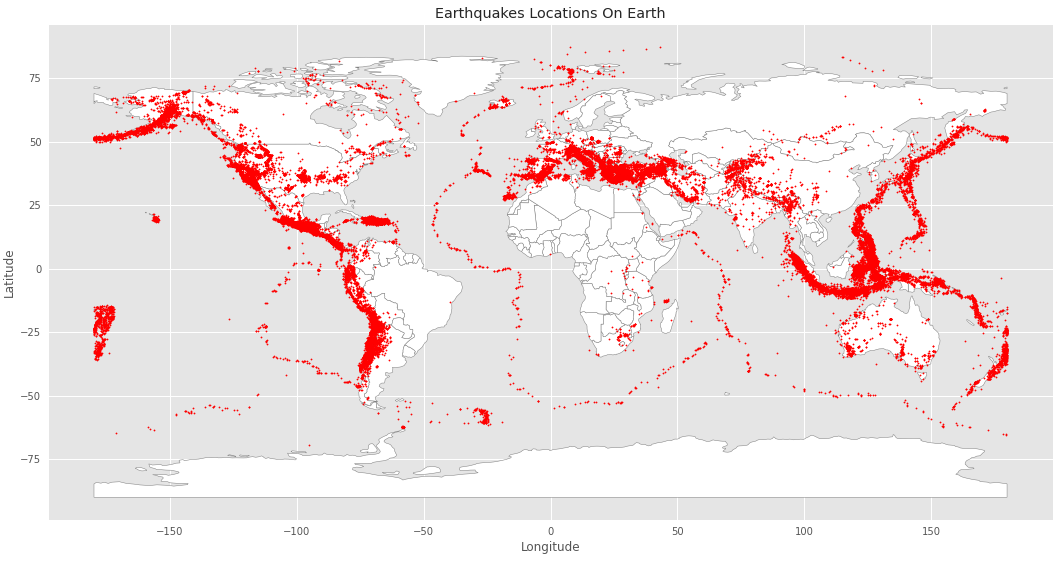

In [22]:
with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10),
               color="white",
               edgecolor = "grey");

    plt.scatter(df.longitude, df.latitude, color="red", alpha=1, s=1.5)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Earthquakes Locations On Earth");

By looking at this map we can clearly differenciate Earth tectonic plates, with the earthquakes happening on their borders.

### Earthquakes by date

In [23]:

#creating crosstab by date, that will show total quantity earthquakes per each day
timeseries_df = pd.crosstab(index = df_2020.date_time_utc.dt.date, columns='Count').reset_index()
timeseries_df.date_time_utc = pd.to_datetime(timeseries_df.date_time_utc)
timeseries_df.head()

col_0,date_time_utc,Count
0,2020-01-01,302
1,2020-01-02,205
2,2020-01-03,167
3,2020-01-04,124
4,2020-01-05,129


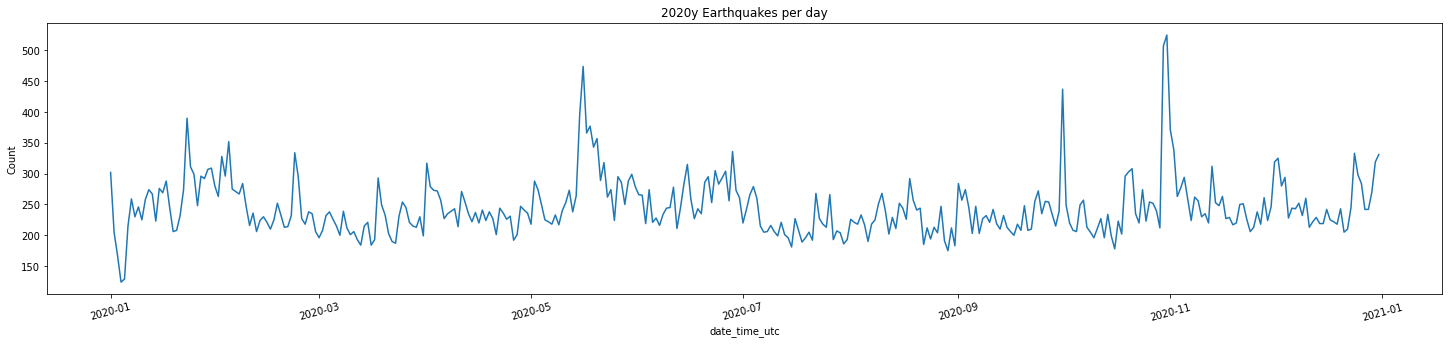

In [24]:
#Plotting timeseries
plt.figure(figsize=(25,5))
sns.lineplot(x="date_time_utc", y="Count", data=timeseries_df)
plt.xticks(rotation=15)
plt.title('2020y Earthquakes per day')
plt.show()

### Earthquakes by Hour

In [25]:
#creating crosstab by date, that will show total quantity earthquakes per each day
timeseries_hourly_df = df_2020.copy()
timeseries_hourly_df['Count']=1
timeseries_hourly_df = timeseries_hourly_df.groupby(timeseries_hourly_df.date_time_utc.dt.hour).agg('sum')
timeseries_hourly_df=timeseries_hourly_df[['Count']]
timeseries_hourly_df

,Count
date_time_utc,
0,3380
1,3412
2,3585
3,3575
4,3645
5,3560
6,3732
7,4128
8,4085


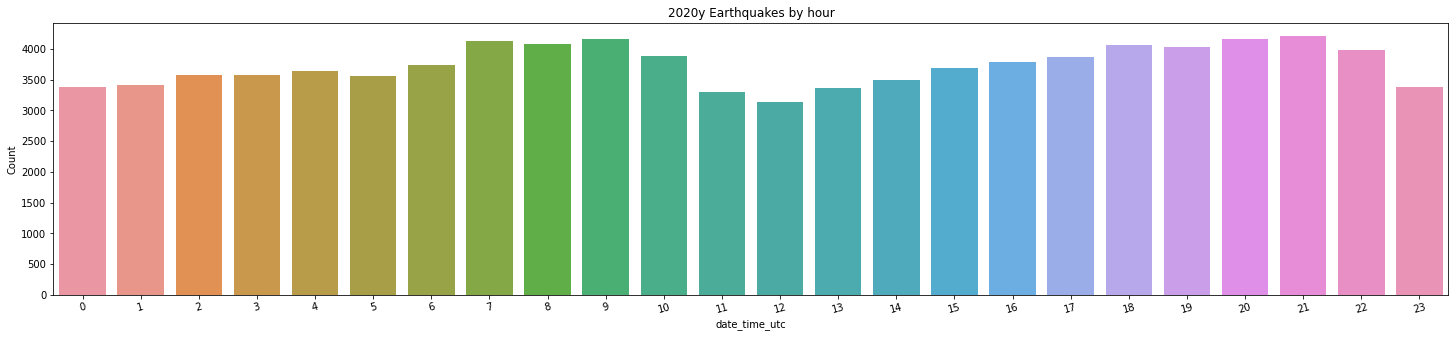

In [26]:
#Plotting timeseries
plt.figure(figsize=(25,5))
sns.barplot(x=timeseries_hourly_df.index, y="Count", data=timeseries_hourly_df)
plt.xticks(rotation=15)
plt.title('2020y Earthquakes by hour')
plt.show()

We can clearly see that there is a 12 hour cycle in the amount of the earthquakes with peaks at 07-10:00 am and 07-10:00 pm. 

## By magnitude

### Earthquakes Magnitudes

In [27]:
#new subset for magnitude
magnitude_df = df.copy()

#creating new feature and grouping by magnitude
magnitude_df['magnitude_group'] = magnitude_df.magnitude
magnitude_df.loc[magnitude_df.magnitude <1, 'magnitude_group'] = '0-0.9'
magnitude_df.loc[(magnitude_df.magnitude >=1)&(magnitude_df.magnitude <2), 'magnitude_group'] = '1-1.9'
magnitude_df.loc[(magnitude_df.magnitude >=2)&(magnitude_df.magnitude <3), 'magnitude_group'] = '2-2.9'
magnitude_df.loc[(magnitude_df.magnitude >=3)&(magnitude_df.magnitude <4), 'magnitude_group'] = '3-3.9'
magnitude_df.loc[(magnitude_df.magnitude >=4)&(magnitude_df.magnitude <5), 'magnitude_group'] = '4-4.9'
magnitude_df.loc[(magnitude_df.magnitude >=5)&(magnitude_df.magnitude <6), 'magnitude_group'] = '5-5.9'
magnitude_df.loc[(magnitude_df.magnitude >=6)&(magnitude_df.magnitude <7), 'magnitude_group'] = '6-6.9'
magnitude_df.loc[magnitude_df.magnitude >=7, 'magnitude_group'] = '7-7.9'

#amount of earthquakes in each group
Cross_tab(magnitude_df, 'magnitude_group')

col_0,magnitude_group,Count
2,2-2.9,42591
3,3-3.9,31768
4,4-4.9,12905
1,1-1.9,1524
5,5-5.9,1408
0,0-0.9,587
6,6-6.9,115
7,7-7.9,8


In [28]:
#creating a dict with subsets for each magnitude group
mag_dfs = {}

mag_dfs = {elem : pd.DataFrame() for elem in magnitude_df.magnitude_group.sort_values().unique()}
for i in mag_dfs:
    mag_dfs[i] = pd.DataFrame(magnitude_df.loc[magnitude_df.magnitude_group==i])

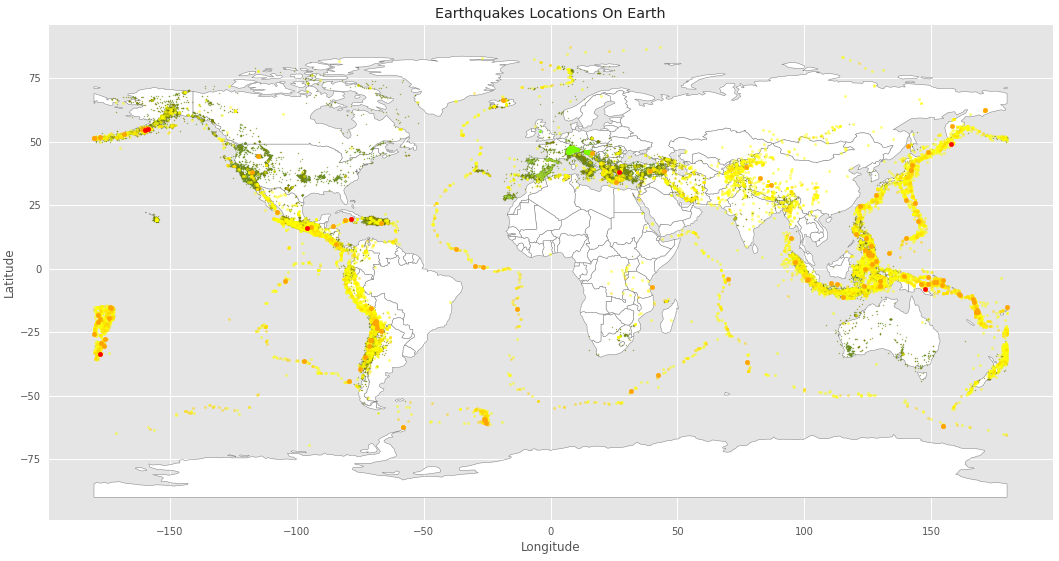

In [29]:
with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10),
               color="white",
               edgecolor = "grey");

    plt.scatter(mag_dfs['2-2.9'].longitude, mag_dfs['2-2.9'].latitude, color='olivedrab', alpha=0.5, s=1, )
    plt.scatter(mag_dfs['3-3.9'].longitude, mag_dfs['3-3.9'].latitude, color='olive', alpha=0.5, s=1)
    plt.scatter(mag_dfs['4-4.9'].longitude, mag_dfs['4-4.9'].latitude, color='yellow', alpha=0.5, s=5)
    plt.scatter(mag_dfs['1-1.9'].longitude, mag_dfs['1-1.9'].latitude, color='yellowgreen', alpha=0.5, s=1)
    plt.scatter(mag_dfs['5-5.9'].longitude, mag_dfs['5-5.9'].latitude, color='gold', alpha=0.5, s=5)
    plt.scatter(mag_dfs['0-0.9'].longitude, mag_dfs['0-0.9'].latitude, color='lawngreen', alpha=1, s=5)
    plt.scatter(mag_dfs['6-6.9'].longitude, mag_dfs['6-6.9'].latitude, color='orange', alpha=1, s=20)
    plt.scatter(mag_dfs['7-7.9'].longitude, mag_dfs['7-7.9'].latitude, color='red', alpha=1, s=20)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Earthquakes Locations On Earth");

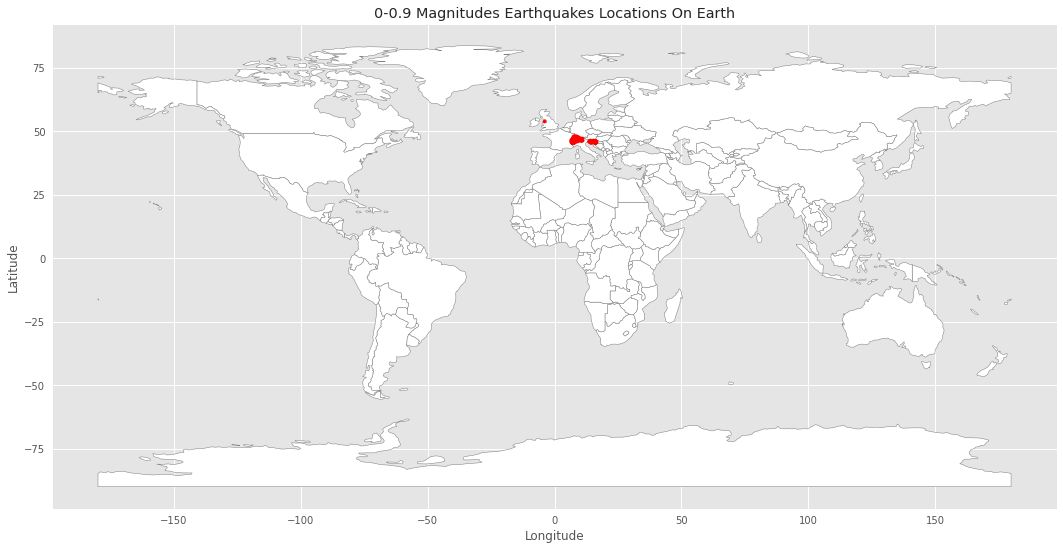

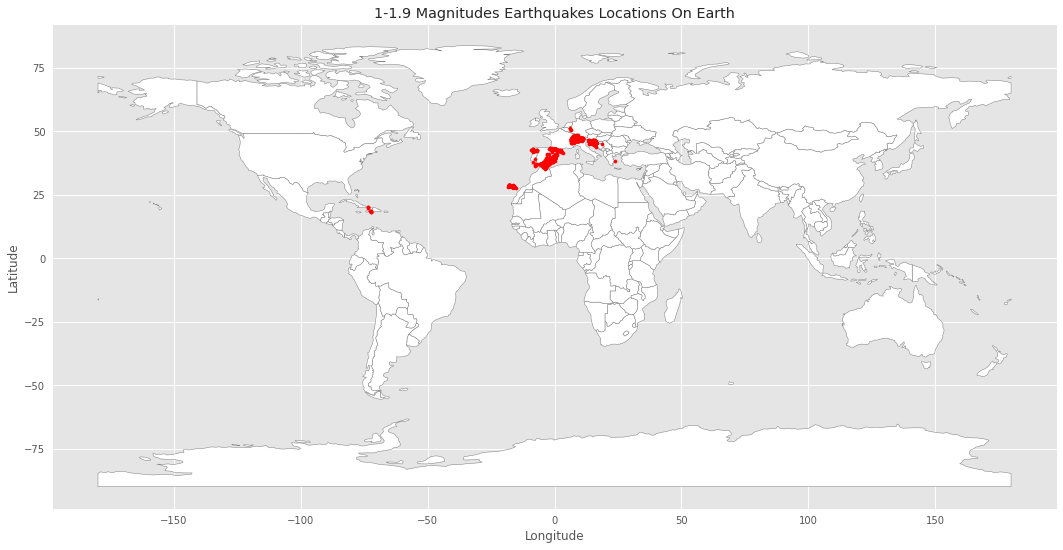

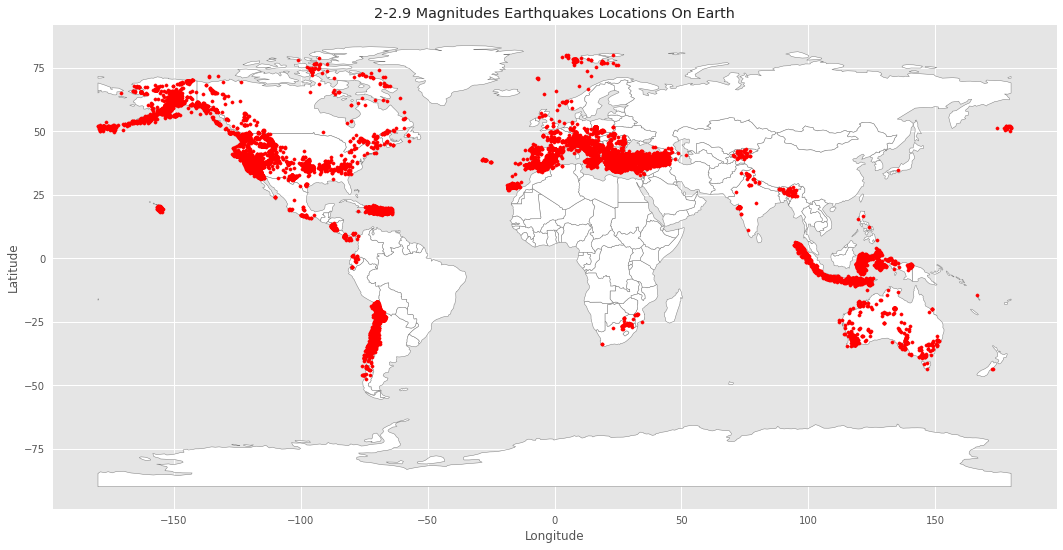

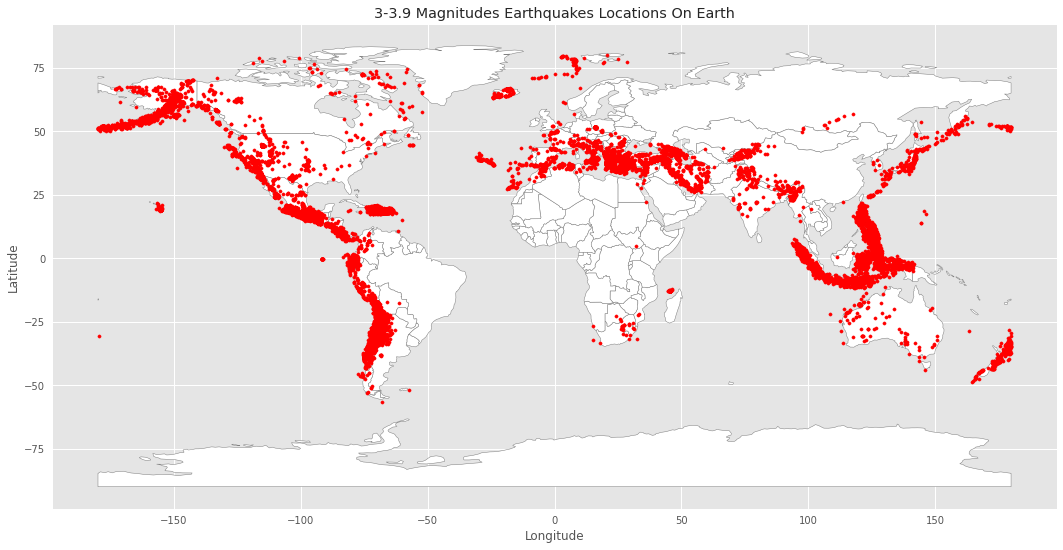

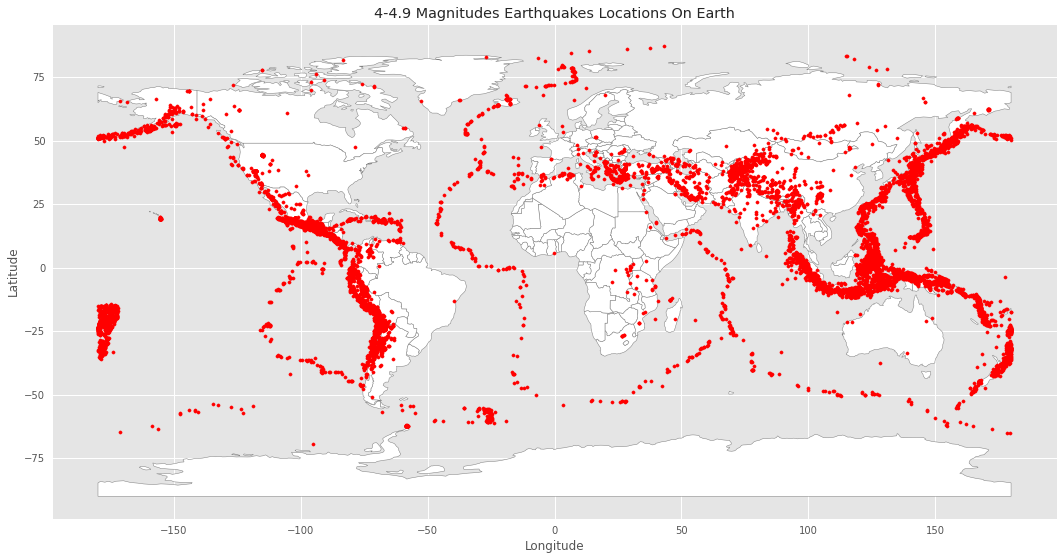

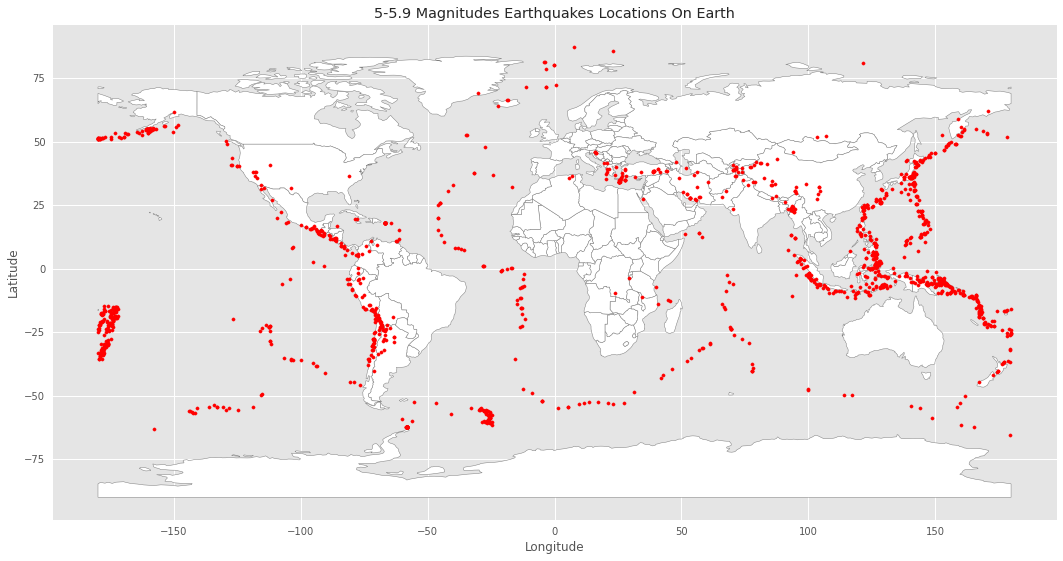

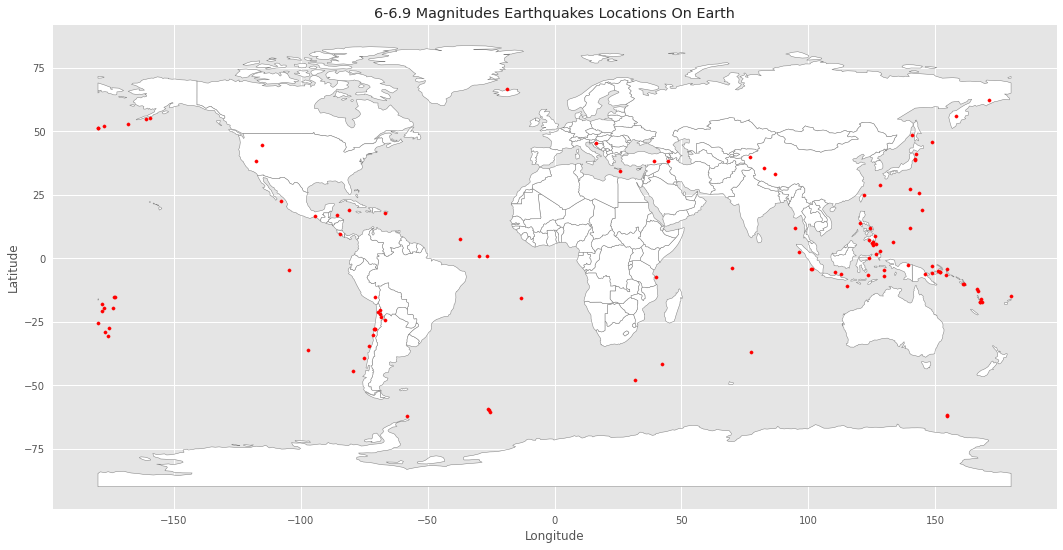

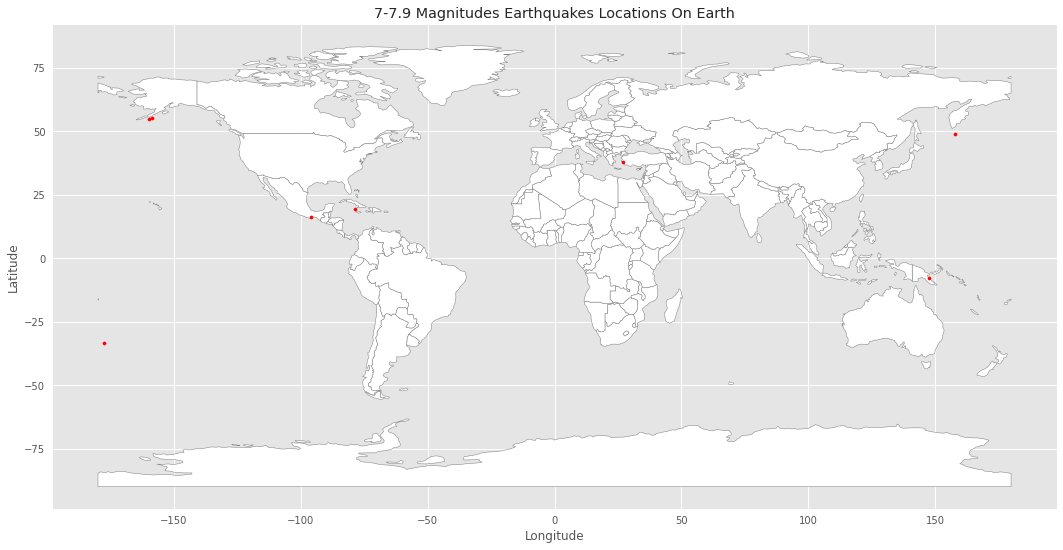

In [30]:
#Map for each magnitude group separately
for i in mag_dfs:
  with plt.style.context(("seaborn", "ggplot")):
      world.plot(figsize=(18,10),
                color="white",
                edgecolor = "grey");

      plt.scatter(mag_dfs[i].longitude, mag_dfs[i].latitude, color='red', alpha=1, s=10)
      plt.xlabel("Longitude")
      plt.ylabel("Latitude")
      plt.title("{} Magnitudes Earthquakes Locations On Earth".format(i))

### Earthquakes by magnitude and time

In [31]:
for i in mag_dfs:
  print(i, ' magnitude earthquakes most often happen at ',round( mag_dfs[i].date_time_utc.dt.hour.mode()[0]), " o'clock")

0-0.9  magnitude earthquakes most often happen at  0  o'clock
1-1.9  magnitude earthquakes most often happen at  14  o'clock
2-2.9  magnitude earthquakes most often happen at  2  o'clock
3-3.9  magnitude earthquakes most often happen at  9  o'clock
4-4.9  magnitude earthquakes most often happen at  16  o'clock
5-5.9  magnitude earthquakes most often happen at  10  o'clock
6-6.9  magnitude earthquakes most often happen at  22  o'clock
7-7.9  magnitude earthquakes most often happen at  2  o'clock


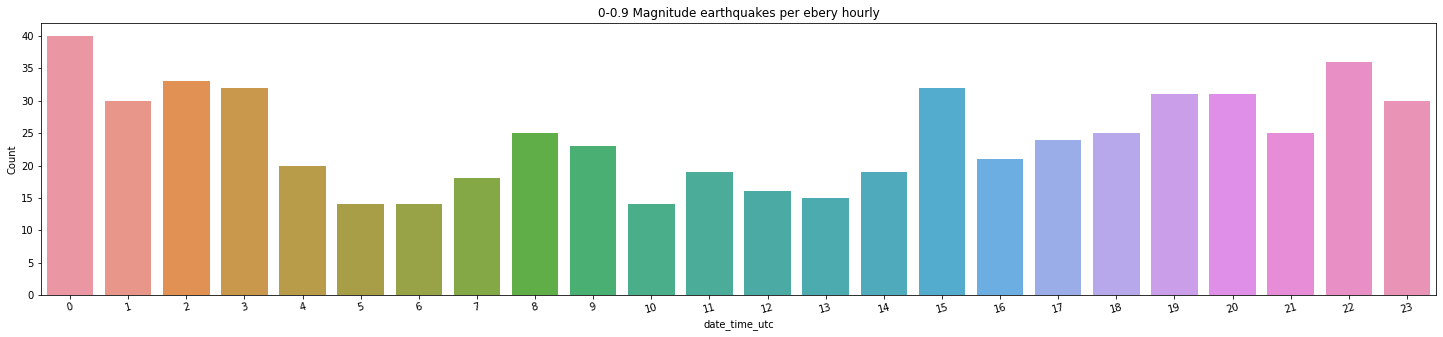

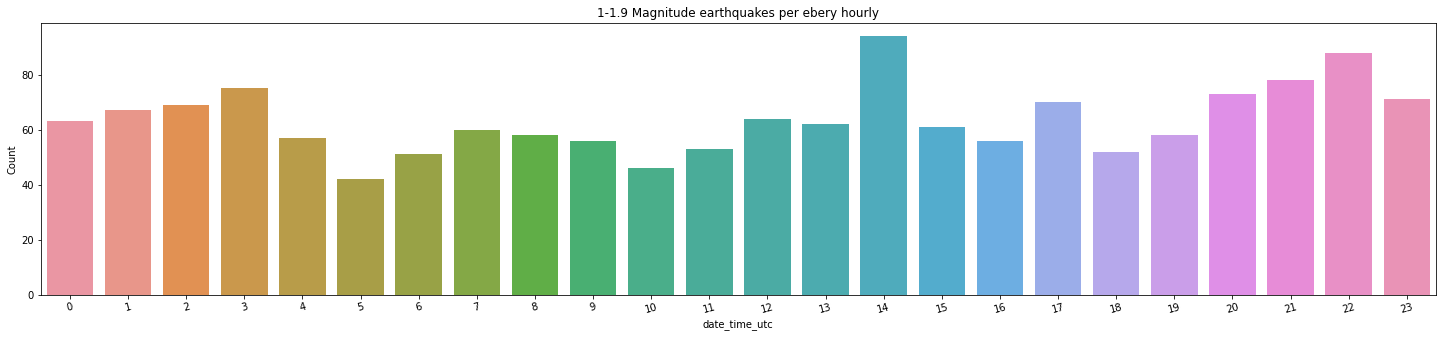

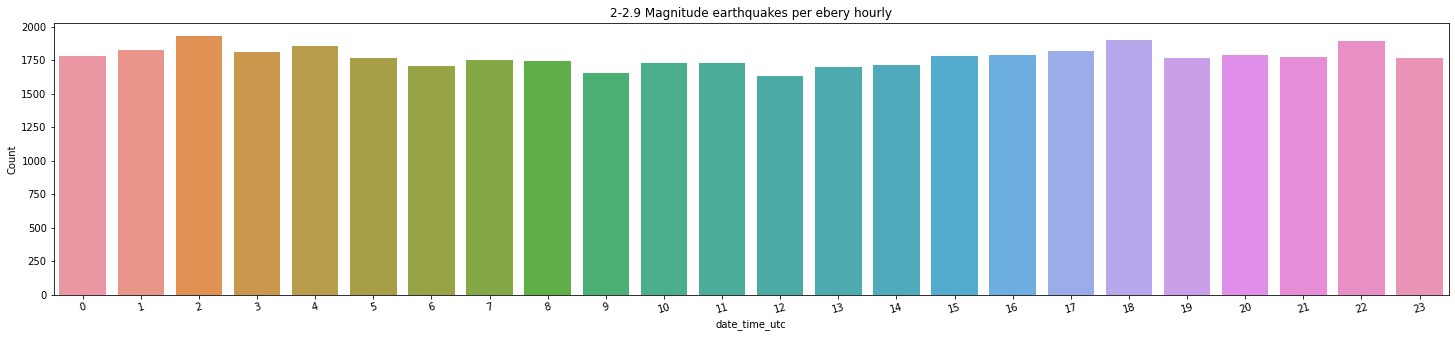

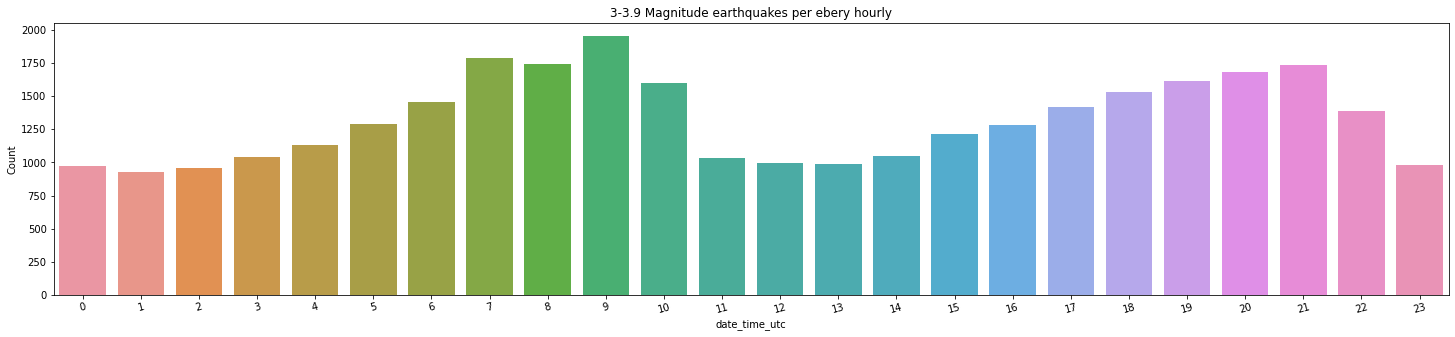

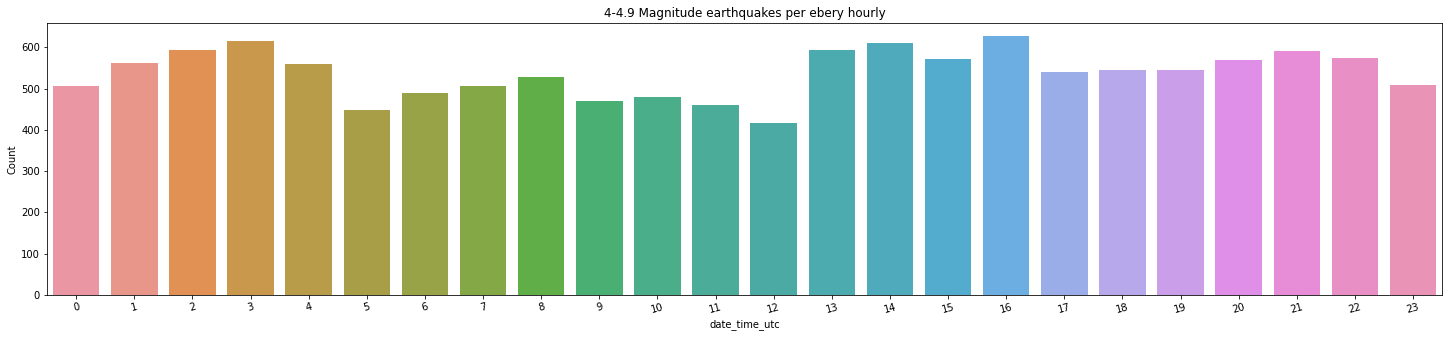

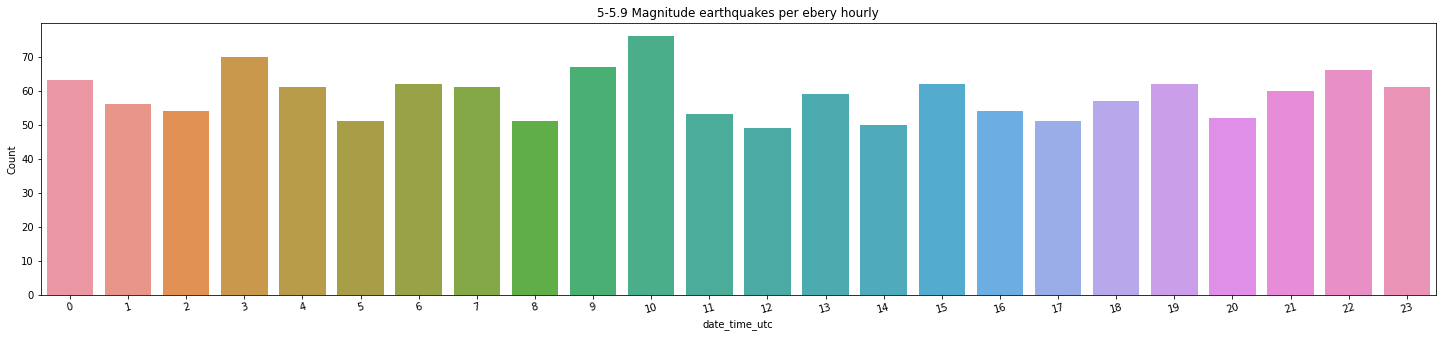

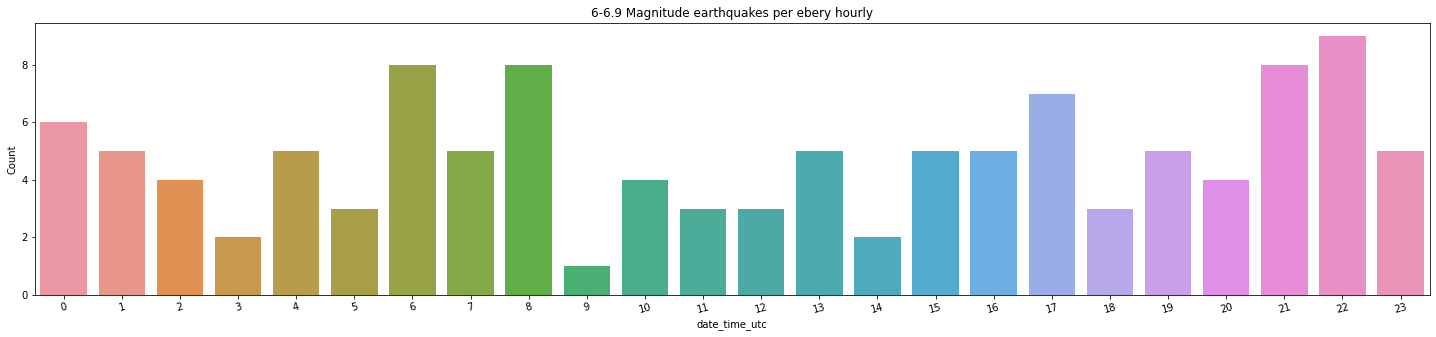

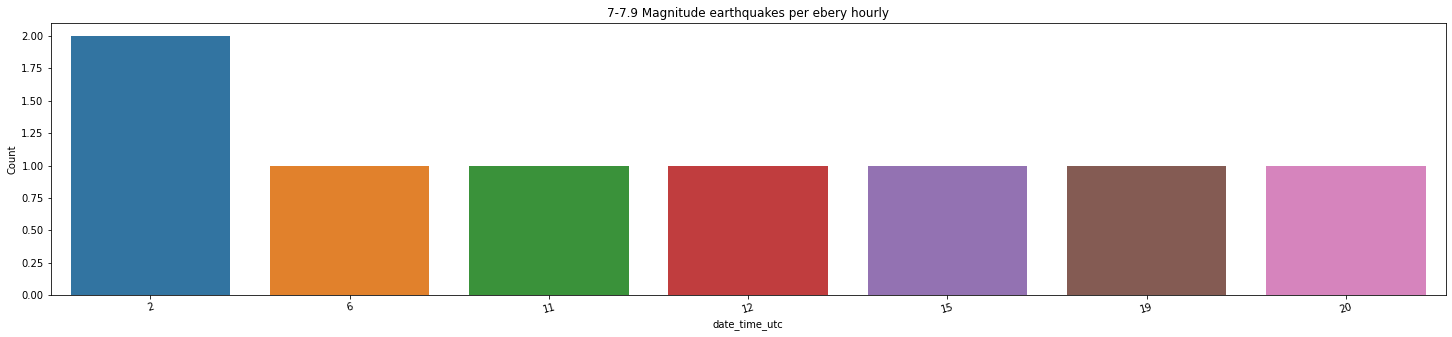

In [32]:
for i in mag_dfs:
  timeseries_mag_dfs = pd.crosstab(index = mag_dfs[i].date_time_utc.dt.hour, columns='Count').reset_index()
  
  #Plotting timeseries
  plt.figure(figsize=(25,5))
  sns.barplot(x="date_time_utc", y="Count", data=timeseries_mag_dfs)
  plt.xticks(rotation=15)
  plt.title('{} Magnitude earthquakes per ebery hourly'.format(i))
  plt.show()

In [33]:
Cross_tab(magnitude_df, 'magnitude_group')

col_0,magnitude_group,Count
2,2-2.9,42591
3,3-3.9,31768
4,4-4.9,12905
1,1-1.9,1524
5,5-5.9,1408
0,0-0.9,587
6,6-6.9,115
7,7-7.9,8


## Earthquakes by region

### Overall view

In [34]:
Cross_tab(df, 'region_name').head(10)

col_0,region_name,Count
594,PUERTO RICO REGION,6694
78,CALIFORNIA,5029
249,"ISLAND OF HAWAII, HAWAII",3716
422,NEVADA,3472
485,"OAXACA, MEXICO",3407
821,WESTERN TURKEY,2552
167,EASTERN TURKEY,2200
593,PUERTO RICO,2179
702,SOUTHERN IDAHO,2059
548,"OFFSHORE OAXACA, MEXICO",1850


We can see that top 10 regions are as shown above. Let's take a closer look at them.

In [35]:
top10_regions = []
for i in Cross_tab(df, 'region_name').head(10).region_name:
  top10_regions.append(i)

In [36]:
df_top10 = df.loc[df.region_name.isin(top10_regions)]

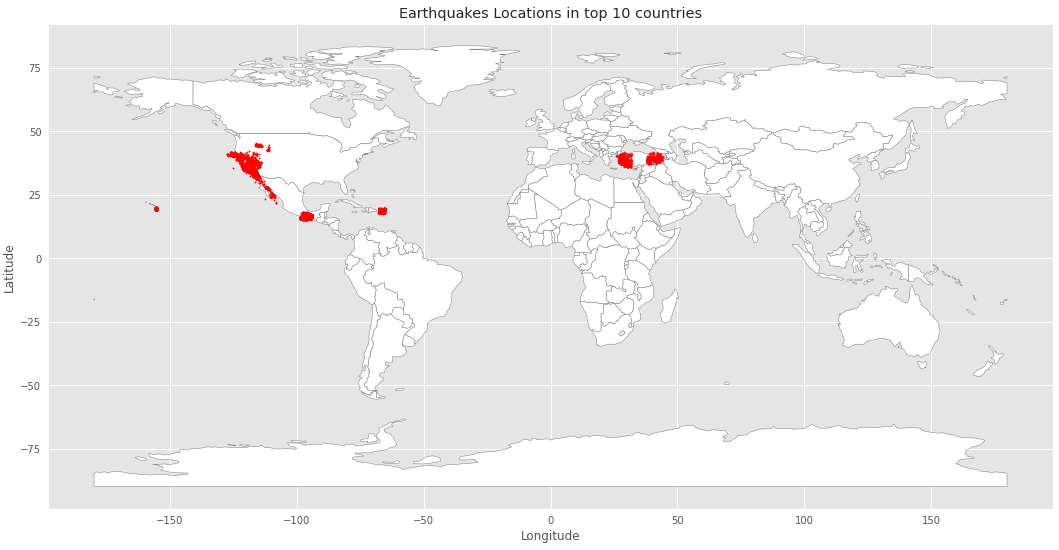

In [37]:
with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10),
               color="white",
               edgecolor = "grey");

    plt.scatter(df_top10.longitude, df_top10.latitude, color="red", alpha=1, s=1.5)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Earthquakes Locations in top 10 countries");

In [38]:
%%html
<img src='https://external-content.duckduckgo.com/iu/?u=http://planetolog.com/maps/map-world/big/tectonic-world-map.gif&f=1&nofb=1' />

You can see that all except Hawaii region are located not only on tectonic plates borders but on a smaller plate, for example: \


*   Turkey on Anatolian plate that is squeezed between 3 other plates 
*   Puerto Rico on Carribean plate that is between 4 plates
*   The West coast of North America is right on the border of tectonic plates and also has 2 smaller plates in between.





### Top 10 countries

In [39]:
#creating a dict with subsets for each magnitude group
top10_dfs = {}

top10_dfs = {elem : pd.DataFrame() for elem in top10_regions}
for i in top10_dfs:
    top10_dfs[i] = pd.DataFrame(df_top10.loc[df_top10.region_name==i])

In [40]:
for i in top10_dfs:

  print('{} region has:\n average magnitude of {}, min{}, max:{}, most_often:{}'.format(i, round(top10_dfs[i].magnitude.mean(),1),top10_dfs[i].magnitude.min(),
                                                                                        top10_dfs[i].magnitude.max(),top10_dfs[i].magnitude.mode()[0] ))

PUERTO RICO REGION region has:
 average magnitude of 2.7, min2.0, max:6.4, most_often:2.5
CALIFORNIA region has:
 average magnitude of 2.5, min2.0, max:5.8, most_often:2.1
ISLAND OF HAWAII, HAWAII region has:
 average magnitude of 2.3, min2.0, max:4.7, most_often:2.1
NEVADA region has:
 average magnitude of 2.4, min2.0, max:6.5, most_often:2.0
OAXACA, MEXICO region has:
 average magnitude of 3.6, min2.8, max:7.4, most_often:3.5
WESTERN TURKEY region has:
 average magnitude of 2.6, min2.0, max:5.6, most_often:2.0
EASTERN TURKEY region has:
 average magnitude of 2.6, min2.0, max:6.8, most_often:2.0
PUERTO RICO region has:
 average magnitude of 2.6, min2.0, max:4.8, most_often:2.5
SOUTHERN IDAHO region has:
 average magnitude of 2.6, min2.0, max:6.5, most_often:2.4
OFFSHORE OAXACA, MEXICO region has:
 average magnitude of 3.8, min2.9, max:5.5, most_often:3.8


We can see that all of these regions had earthquakes with min magnitude of 2. But on the other hand none of them had more that 6.5 magnitude \
I can speculate that regions with most often earthquakes have less magnitude??

### Top 10 regions by magnitude

In [44]:
df_2020.loc[df_2020.magnitude>=7]

,date_time_utc,latitude,longitude,depth,magnitude_type,magnitude,region_name,Countries
6876,2020-01-28 19:10:25,19.37,-78.85,10,MW,7.7,CUBA REGION,CUBA
20279,2020-03-25 02:49:21,48.98,157.73,60,MW,7.5,EAST OF KURIL ISLANDS,RUSSIA
42162,2020-06-18 12:49:53,-33.41,-177.81,8,MW,7.4,SOUTH OF KERMADEC ISLANDS,NEW ZEALAND
43533,2020-06-23 15:29:04,16.10,-95.91,10,MW,7.4,"OAXACA, MEXICO",MEXICO
49205,2020-07-17 02:50:23,-7.83,147.73,80,MW,7.0,"EASTERN NEW GUINEA REG., P.N.G.",Papua New Guinea
50222,2020-07-22 06:12:44,55.14,-158.56,30,MW,7.8,ALASKA PENINSULA,U.S.
70558,2020-10-19 20:54:40,54.70,-159.76,40,MW,7.5,SOUTH OF ALASKA,U.S.
73286,2020-10-30 11:51:25,37.91,26.84,10,MW,7.0,"DODECANESE ISLANDS, GREECE",GREECE


**I will update this work soon :)**